In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [4]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias', 
                                      shape=[self.dense.input_shape[-1]], 
                                      initializer='zeros')
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2,
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.SGD(learning_rate=1.5), 
                metrics=[rounded_accuracy])

In [6]:
history = tied_ae.fit(x_train, x_train, epochs=10, 
                      validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3013 - val_rounded_accuracy: 0.9094
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2872 - val_rounded_accuracy: 0.9319
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

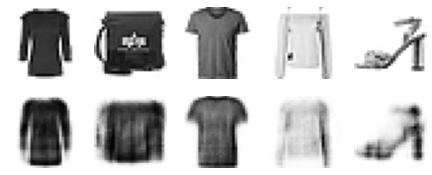

In [7]:
show_reconstructions(tied_ae)
plt.show()

In [8]:
def train_autoencoder(n_neurons, x_train, x_valid, loss, optimizer, 
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = x_train.shape[-1]
    
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation='selu', input_shape=[n_inputs])
    ])
    
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation)
    ])
    
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(x_train, x_train, epochs=n_epochs, 
                    validation_data=(x_valid, x_valid))
    return encoder, decoder, encoder(x_train), encoder(x_valid)

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

K = keras.backend
x_train_flat = K.batch_flatten(x_train)
x_valid_flat = K.batch_flatten(x_valid)

enc1, dec1, x_train_enc1, x_valid_enc1 = train_autoencoder(
    100, 
    x_train_flat, 
    x_valid_flat, 
    'binary_crossentropy', 
    keras.optimizers.SGD(learning_rate=1.5), 
    output_activation='sigmoid', 
    metrics=[rounded_accuracy]
)

enc2, dec2, _, _ = train_autoencoder(
    30, 
    x_train_enc1, 
    x_valid_enc1, 
    'mse', 
    keras.optimizers.SGD(learning_rate=0.05), 
    output_activation='selu'
)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [10]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

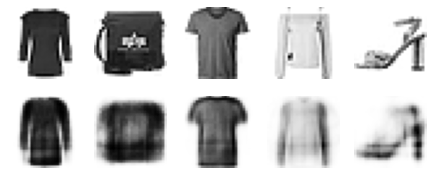

In [11]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [12]:
stacked_ae_1_by_1.compile(loss='binary_crossentropy', 
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), 
                          metrics=[rounded_accuracy])

history = stacked_ae_1_by_1.fit(x_train, x_train, epochs=10, 
                                validation_data=(x_valid, x_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9351
Epoch 7/10
1719/1719 [==================

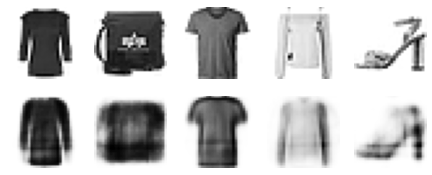

In [13]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()